In [ ]:
# Implementation of word2vec on the IMDB 5000 dataset

In [2]:
from __future__ import absolute_import, division, print_function
import multiprocessing, os, pprint, re
import gensim.models.word2vec as word2vec
import sklearn.manifold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, string

In [3]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('movie_metadata.csv')

In [4]:
df = df.drop(df.movie_imdb_link.name, 1)
def trim_and_remove_spaces(raw):
    if pd.isnull(raw) == False:
        return raw.strip().replace(' ', '_')

df.director_name = df.director_name.apply(trim_and_remove_spaces)
df.actor_2_name = df.actor_2_name.apply(trim_and_remove_spaces)

df.actor_1_name = df.actor_1_name.apply(trim_and_remove_spaces)
df.movie_title = df.movie_title.apply(trim_and_remove_spaces)
df.actor_3_name = df.actor_3_name.apply(trim_and_remove_spaces)
df.language = df.language.apply(trim_and_remove_spaces)
df.country = df.country.apply(trim_and_remove_spaces)

In [5]:
def descretize3(df, col):
    
    if(df[col].dtype == np.float64 or df[col].dtype == np.int64):
        df[col] = pd.qcut(df[col], 3, labels=['low', 'medium', 'high'], retbins=False)
        df[col] = df[col].apply(lambda x : (str(x)).replace(" ", ""))
        
def descretize2(df, col):
    
    if(df[col].dtype == np.float64 or df[col].dtype == np.int64):
        df[col] = pd.qcut(df[col], 2, labels=['low', 'high'], retbins=False)
        df[col] = df[col].apply(lambda x : (str(x)).replace(" ", ""))
        
def descretize10(df, col):
    
    if(df[col].dtype == np.float64 or df[col].dtype == np.int64):
        df[col] = pd.qcut(df[col], 3, labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], retbins=False)
        df[col] = df[col].apply(lambda x : (str(x)).replace(" ", ""))

descretize3(df, df.director_facebook_likes.name)
descretize3(df, df.num_critic_for_reviews.name)
descretize3(df, df.duration.name)
descretize3(df, df.actor_3_facebook_likes.name)
descretize3(df, df.actor_1_facebook_likes.name)

descretize3(df, df.gross.name)
descretize3(df, df.num_voted_users.name)
descretize3(df, df.cast_total_facebook_likes.name)
descretize3(df, df.num_user_for_reviews.name)
descretize3(df, df.budget.name)

descretize3(df, df.actor_2_facebook_likes.name)
descretize3(df, df.imdb_score.name)
descretize2(df, df.facenumber_in_poster.name)
descretize3(df, df.title_year.name)
descretize3(df, df.aspect_ratio.name)
descretize2(df, df.movie_facebook_likes.name)

In [6]:
from sklearn.utils import shuffle
df = shuffle(df)
df

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
307,Color,Edward_Zwick,high,high,high,medium,Djimon_Hounsou,high,high,Adventure|Drama|Thriller,Leonardo_DiCaprio,Blood_Diamond,high,high,Stephen_Collins,low,diamond|elephant|fisherman|rebel|sierra leone,high,English,Germany,R,high,medium,high,high,medium,high
3326,Color,Jeremy_Sims,low,high,low,low,Gyton_Grantley,low,NaN,Drama|History|War,Harrison_Gilbertson,Beneath_Hill_60,low,low,Steve_Le_Marquand,high,blue clay|diversion|ends with biographical not...,low,English,Australia,R,low,high,low,high,medium,low
2004,Color,Giuseppe_Tornatore,medium,high,high,medium,Sean_Buchanan,high,low,Crime|Drama|Mystery|Romance,Jim_Sturgess,The_Best_Offer,high,medium,Liya_Kebede,high,antique|art|heiress|older man younger woman re...,medium,English,Italy,R,medium,high,low,high,medium,high
1610,Color,Barbra_Streisand,low,high,low,medium,Blythe_Danner,medium,high,Drama|Romance,George_Carlin,The_Prince_of_Tides,low,low,Melinda_Dillon,low,new york|psychiatrist|shrimper|south carolina|...,medium,English,USA,R,medium,low,medium,medium,low,high
4257,Color,Kimberly_Peirce,medium,high,medium,low,Brendan_Sexton_III,low,medium,Biography|Crime|Drama|Romance,Alicia_Goranson,Boys_Don't_Cry,high,low,Jeannetta_Arnette,low,drinking|female dressed as male|love|nebraska|...,high,English,USA,R,low,low,low,high,low,low
4625,Color,Robert_Heath,low,low,low,low,Alexander_Vlahos,low,NaN,Horror|Mystery,David_Oakes,Truth_or_Die,low,low,Jennie_Jacques,high,cabin in the woods|drinking acid|introvert|les...,low,English,UK,Not Rated,low,high,low,low,medium,high
1655,Color,Martin_Brest,medium,high,medium,medium,Yaphet_Kotto,high,medium,Action|Comedy|Crime|Thriller,Robert_De_Niro,Midnight_Run,medium,high,Philip_Baker_Hall,low,accountant|bounty hunter|fbi|mafia|mob,medium,English,USA,R,medium,low,medium,high,low,low
3791,Color,Dennis_Hopper,low,low,low,low,Don_Gordon,low,NaN,Drama,Raymond_Burr,Out_of_the_Blue,low,low,Jim_Byrnes,low,explosion|hitchhiking|punk|trauma|truck driver,low,English,Canada,R,low,low,low,high,low,high
4,NaN,Doug_Walker,NaN,NaN,high,NaN,Rob_Walker,low,NaN,Documentary,Doug_Walker,Star_Wars:_Episode_VII_-_The_Force_Awakens,low,low,None,low,NaN,NaN,None,None,NaN,NaN,NaN,low,high,NaN,low
1400,Color,Tim_Burton,high,high,high,medium,Jack_Palance,medium,high,Action|Adventure,Michael_Gough,Batman,high,medium,William_Hootkins,low,city|dc comics|gotham|pantyhose|police,high,English,USA,PG-13,high,low,medium,high,low,high


In [7]:
raw_sentences = []
for a in df.iterrows():
    words = []    
    for b in a[1].iteritems():
        if b[0] == 'genres':
            for g in str(b[1]).split("|"):
                words.append('genre')
                words.append(trim_and_remove_spaces(g.lower()))
        elif b[0] == 'plot_keywords':
            for p in str(b[1]).split("|"):
                words.append('plot')
                words.append(trim_and_remove_spaces(p.lower()))
        elif b[0] in ['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name']:
            words.append(str(b[0]))
            words.append(str(b[1]))
        else:
            words.append(str(b[0]) + "_" + str(b[1]))
    raw_sentences.append(' '.join(words))

In [8]:
def sentence_to_wordlist(raw):
    words = raw.split()
    return words

tokenized_sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        tokenized_sentences.append(sentence_to_wordlist(raw_sentence))

In [9]:
token_count = sum([len(sentence) for sentence in tokenized_sentences])
print('Total token count = {0:,}'.format(token_count))

Total token count = 224,498


In [10]:
tokenized_sentences[51]

['color_Color',
 'director_name',
 'Edgar_Wright',
 'num_critic_for_reviews_high',
 'duration_medium',
 'director_facebook_likes_high',
 'actor_3_facebook_likes_low',
 'actor_2_name',
 'Thomas_Law',
 'actor_1_facebook_likes_low',
 'gross_medium',
 'genre',
 'action',
 'genre',
 'comedy',
 'genre',
 'sci-fi',
 'actor_1_name',
 'Michael_Smiley',
 "movie_title_The_World's_End",
 'num_voted_users_high',
 'cast_total_facebook_likes_low',
 'actor_3_name',
 'Jasper_Levine',
 'facenumber_in_poster_high',
 'plot',
 'alcoholic',
 'plot',
 'doppelganger',
 'plot',
 'group_therapy',
 'plot',
 'self_mutilation',
 'plot',
 'twin_actresses_for_twin_sisters',
 'num_user_for_reviews_high',
 'language_English',
 'country_UK',
 'content_rating_R',
 'budget_medium',
 'title_year_high',
 'actor_2_facebook_likes_low',
 'imdb_score_medium',
 'aspect_ratio_medium',
 'movie_facebook_likes_high']

In [70]:
# Hyperparameters and training

num_features = 128
min_word_count = 1
num_workers = multiprocessing.cpu_count()
context_size = 50
downsampling = 1e-3
seed = 123

model = word2vec.Word2Vec(
    tokenized_sentences,
    sg=0, # for CBOW
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling,
    iter=30
)

In [ ]:
# Compress the model to 2D
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = model.wv.syn0
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [75]:
from sklearn.decomposition import PCA
all_word_vectors_matrix = model.wv.syn0
pca = PCA(n_components=2)
all_word_vectors_matrix_2d = pca.fit_transform(all_word_vectors_matrix)

In [76]:
colors = {'genre': 1, 'plot': 1, 'director':3}
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

%pylab inline



Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [77]:
points['color'] = 0

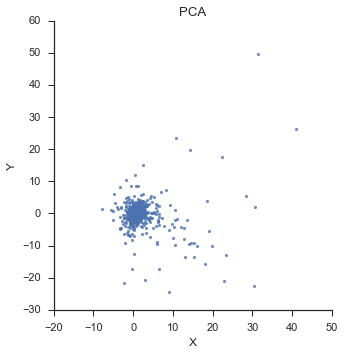

In [78]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

sns.lmplot('x', 'y',
           data=points,
           fit_reg=False,
           scatter_kws={"marker": "D",
                        "s": 10})
plt.title('PCA')
plt.xlabel('X')
plt.ylabel('Y')

In [79]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

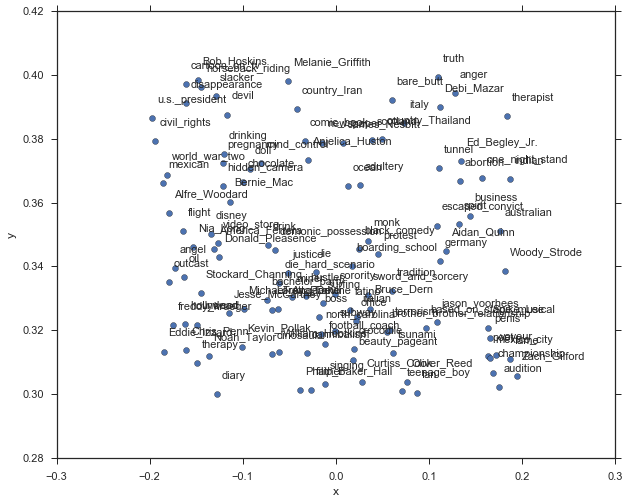

In [18]:
plot_region(x_bounds=(-0.2, 0.2), y_bounds=(0.3, 0.4))

In [57]:
model.wv.most_similar(positive=['Jason_Statham'], negative=['action'])

[('Norman_Reedus', 0.655038058757782),
 ('coke', 0.5935384035110474),
 ('movie_title_RocknRolla', 0.5640352368354797),
 ('movie_title_Blood_Work', 0.5547969341278076),
 ('Jennifer_Hale', 0.5499940514564514),
 ('oklahoma', 0.5477864146232605),
 ('getaway_driver', 0.5308957099914551),
 ('Robert_Rodriguez', 0.5218404531478882),
 ('gay_cop', 0.5205907225608826),
 ('killed_in_an_elevator', 0.5132497549057007)]

In [67]:
def likeBradPitt(v):
    if not v:
        return False
    return str(v) != 'Robin_Williams' and model.wv.similarity(v, 'Robin_Williams') > 0.8

def likeToken(v, token):
    try:
        return model.wv.similarity(v, token) > 0.5
    except:
        return False

In [71]:
df1 = df[(df.movie_title.apply(lambda y: likeToken('movie_title_' + y, 'Leonardo_DiCaprio')))]

In [73]:
df2 = df[(df.actor_1_name == 'Leonardo_DiCaprio') | (df.actor_2_name == 'Leonardo_DiCaprio') | (df.actor_3_name == 'Leonardo_DiCaprio')]

In [83]:
df.actor_3_name.value_counts()

Ben_Mendelsohn          8
Steve_Coogan            8
John_Heard              8
Stephen_Root            7
Anne_Hathaway           7
Sam_Shepard             7
Lois_Maxwell            7
Jon_Gries               7
Kirsten_Dunst           7
Robert_Duvall           7
Kris_Marshall           6
Kevin_Pollak            6
Ellen_Barkin            6
Joan_Allen              6
Kevin_Dunn              6
Reg_E._Cathey           6
Tom_Wilkinson           6
Mike_Epps               6
Hope_Davis              6
Jordi_Mollà             6
Clifton_Collins_Jr.     6
Paul_Sorvino            6
Shawn_Hatosy            6
John_Gielgud            6
Thomas_Lennon           6
Jose_Pablo_Cantillo     6
Steve_Carell            6
Bruce_McGill            6
Craig_T._Nelson         6
Bob_Gunton              5
                       ..
India_de_Beaufort       1
Ian_McNeice             1
Diana_Maria_Riva        1
Alexa_PenaVega          1
Gbenga_Akinnagbe        1
Red_Skelton             1
Peter_Onorati           1
Felicia_Pear

In [85]:
model.wv.similarity('movie_title_Django_Unchained', 'Leonardo_DiCaprio')

KeyError: "word 'Django_Unchained' not in vocabulary"

In [86]:
df

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
307,Color,Edward_Zwick,high,high,high,medium,Djimon_Hounsou,high,high,Adventure|Drama|Thriller,Leonardo_DiCaprio,Blood_Diamond,high,high,Stephen_Collins,low,diamond|elephant|fisherman|rebel|sierra leone,high,English,Germany,R,high,medium,high,high,medium,high
3326,Color,Jeremy_Sims,low,high,low,low,Gyton_Grantley,low,NaN,Drama|History|War,Harrison_Gilbertson,Beneath_Hill_60,low,low,Steve_Le_Marquand,high,blue clay|diversion|ends with biographical not...,low,English,Australia,R,low,high,low,high,medium,low
2004,Color,Giuseppe_Tornatore,medium,high,high,medium,Sean_Buchanan,high,low,Crime|Drama|Mystery|Romance,Jim_Sturgess,The_Best_Offer,high,medium,Liya_Kebede,high,antique|art|heiress|older man younger woman re...,medium,English,Italy,R,medium,high,low,high,medium,high
1610,Color,Barbra_Streisand,low,high,low,medium,Blythe_Danner,medium,high,Drama|Romance,George_Carlin,The_Prince_of_Tides,low,low,Melinda_Dillon,low,new york|psychiatrist|shrimper|south carolina|...,medium,English,USA,R,medium,low,medium,medium,low,high
4257,Color,Kimberly_Peirce,medium,high,medium,low,Brendan_Sexton_III,low,medium,Biography|Crime|Drama|Romance,Alicia_Goranson,Boys_Don't_Cry,high,low,Jeannetta_Arnette,low,drinking|female dressed as male|love|nebraska|...,high,English,USA,R,low,low,low,high,low,low
4625,Color,Robert_Heath,low,low,low,low,Alexander_Vlahos,low,NaN,Horror|Mystery,David_Oakes,Truth_or_Die,low,low,Jennie_Jacques,high,cabin in the woods|drinking acid|introvert|les...,low,English,UK,Not Rated,low,high,low,low,medium,high
1655,Color,Martin_Brest,medium,high,medium,medium,Yaphet_Kotto,high,medium,Action|Comedy|Crime|Thriller,Robert_De_Niro,Midnight_Run,medium,high,Philip_Baker_Hall,low,accountant|bounty hunter|fbi|mafia|mob,medium,English,USA,R,medium,low,medium,high,low,low
3791,Color,Dennis_Hopper,low,low,low,low,Don_Gordon,low,NaN,Drama,Raymond_Burr,Out_of_the_Blue,low,low,Jim_Byrnes,low,explosion|hitchhiking|punk|trauma|truck driver,low,English,Canada,R,low,low,low,high,low,high
4,NaN,Doug_Walker,NaN,NaN,high,NaN,Rob_Walker,low,NaN,Documentary,Doug_Walker,Star_Wars:_Episode_VII_-_The_Force_Awakens,low,low,None,low,NaN,NaN,None,None,NaN,NaN,NaN,low,high,NaN,low
1400,Color,Tim_Burton,high,high,high,medium,Jack_Palance,medium,high,Action|Adventure,Michael_Gough,Batman,high,medium,William_Hootkins,low,city|dc comics|gotham|pantyhose|police,high,English,USA,PG-13,high,low,medium,high,low,high
